# **マイドライブへのアクセス**

In [1]:
# マイドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/'My Drive'/研究

/content/drive/My Drive/研究


# **ライブラリのインストール**


In [3]:
# 必要なライブラリを準備
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install gensim
!pip install sentencepiece
!pip install keras_bert
!pip install transformers
!pip install tensorflow==2.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

# **構築済みモデルの読み込み**


In [5]:
from keras_bert import load_trained_model_from_checkpoint

# Bertの構築済みモデルの読み込み
bert = load_trained_model_from_checkpoint('sentencepiece+bert/bert_config.json', 'sentencepiece+bert/model.ckpt-1400000', training=False, trainable=False)
bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 512, 768), ( 24576000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 512, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [6]:
import sentencepiece as spm

# SentencePieceの構築済みモデルの読み込み
sp = spm.SentencePieceProcessor()
sp.Load('sentencepiece+bert/wiki-ja.model')

True

# **データセットの準備**


In [7]:
import pandas as pd
import glob

# マイドライブのデータセットの読み込み
csv_files = glob.glob("ver-20200312/*.csv")

columns = ['dialogue', 'MITI_code', 'target']
datasets = pd.DataFrame(index=[], columns=columns)

for csv_file in csv_files:
  # データの読込
  records = pd.read_csv(csv_file, sep=',', encoding='cp932')
  
  # 余分な空白を削除
  records["dialogue"] = records["dialogue"].str.strip()

  # データのtargetを一律に修正
  records.fillna(records.iat[0, 3], inplace=True)

  # データセットを発話単位から対話単位に変換
  co_dialogue = ""
  for index,row in records.iterrows():
    if "Cl" in row["NO"]:
      co_dialogue = row["dialogue"]
    elif co_dialogue != "":
      records.iloc[index, 1] = co_dialogue + "\t" + row["dialogue"]

  # 面接者のみの発話を抽出
  records = records.loc[records['NO'].str.contains('Co'), ["dialogue", "MITI_code", "target"]]

  # 全csvファイルを1つのpandasに結合
  datasets = pd.concat([datasets, records], ignore_index=True)

# ラベル6を除外
datasets = datasets[datasets["MITI_code"] != 6]

# 質問のグループとそれ以外のグループに分割
q_datasets = datasets[(datasets["MITI_code"] == 3) | (datasets["MITI_code"] == 4)]
else_datasets = datasets[(datasets["MITI_code"] != 3) & (datasets["MITI_code"] != 4)]

# ラベルをstr型に変換
q_datasets["MITI_code"] = [str(sentence) for sentence in q_datasets["MITI_code"]]
else_datasets["MITI_code"] = [str(sentence) for sentence in else_datasets["MITI_code"]]


print(q_datasets)
print(else_datasets)

                                              dialogue  ...                    target
0    現状についてお話しいただきありがとうございました。そんな中、こちらのカウンセリングを受けて、...  ...              転職に向けた行動を起こす
9    そうですね。一応会社の規定では、3か月前までに退職願を出さなくてはいけないことになっているの...  ...              転職に向けた行動を起こす
11    はい。\tそうすると、改めて、今日も面談が終わった後には、どんな風になっていると良さそうですか？  ...              転職に向けた行動を起こす
13                   はい\tそれが、今と違ってどのようになっていると、良さそうですか？  ...              転職に向けた行動を起こす
25   実際どうなるかはわからないですけどね。計画的に進められるといいとは思います。\t1日1時間、...  ...              転職に向けた行動を起こす
28                                  はい。\t他にも何かありそうですか？  ...              転職に向けた行動を起こす
30   はい。\tそれでは、1日1時間転職に向けた活動の時間を確保することに対する自信度は10点満点...  ...              転職に向けた行動を起こす
32        そうですね。無理ではないと思います。\t具体的には、どんな風にすることができそうですか？  ...              転職に向けた行動を起こす
33   曜日によって業務内容は変わってくるのですが、月、火、木は1日開発の仕事をしていて、木曜日は英...  ...              転職に向けた行動を起こす
35   はい。いずれも帰宅してしまうと、なかなか作業の時間が取れないことが多いので、帰宅前にやれると...  ...              転職に向けた行動を起こす
38                      はい\tこのように本日は話をしてきましたが、いかがでしたか？

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# **学習と予測**

In [48]:
import numpy as np

def _get_vector(feature):
    """
    データ1文をベクトル化する関数
    引数：(データセットのテキスト1文)
    """
    common_seg_input = np.zeros((1, 512), dtype = np.float32)
    indices = np.zeros((1, 512), dtype = np.float32)

    tokens = []
    tokens.append('[CLS]')

    # SentencePieceでトークン単位に分割
    if "\t" in feature:
      # データが対話形式の場合
      first_sentence, second_sentence = feature.split("\t")
      tokens.extend(sp.encode(first_sentence, out_type=str))
      tokens.append('[SEP]')
      tokens.extend(sp.encode(second_sentence, out_type=str))
    else:
      # データが発話形式の場合
      tokens.extend(sp.encode(feature, out_type=str))
    tokens.append('[SEP]')

    # SentencePieceでトークンIDに変換
    for t, token in enumerate(tokens):
        try:
            indices[0, t] = sp.piece_to_id(token)
        except:
            indices[0, t] = sp.piece_to_id('<unk>')

    # Bertでベクトルに変換
    vector =  bert.predict([indices, common_seg_input])[0]

    # ベクトルの次元数(ndim)を変換
    vector = np.ravel(vector)
    return vector

In [49]:
from sklearn.decomposition import PCA

def _text_to_vectors(text, dimension_num):
    """
    ベクトル化したデータに対して次元削減を行う関数
    引数：(データセットのリスト, 次元削減後の次元数)
    """
    vectors = []
    pca = PCA(n_components=dimension_num)

    #データセットを1文ずつベクトル化
    for sentences in text:
        vectors.append(_get_vector(sentences))

    #PCAで次元削減
    vectors = pca.fit_transform(vectors)
    return vectors

In [84]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Leave-One-Outのインスタンス生成
loo = LeaveOneOut()

# pandasをnumpyに変換
q_x = q_datasets["dialogue"].values
q_y = q_datasets["MITI_code"].values

# SentencePieceとBertを用いてベクトル化
q_x = _text_to_vectors(q_x, 10)

# 予測結果のリスト
q_predict_list = np.empty(0)

# Leave-One-Out手法で学習・予測
for train_index, test_index in loo.split(q_x):

  # 訓練データとテストデータを分割
  x_train, x_test = q_x[train_index], q_x[test_index]
  y_train, y_test = q_y[train_index], q_y[test_index]

  # モデルの学習
  model = LogisticRegression(random_state=46, max_iter=1000, C=0.001)
  model.fit(x_train, y_train)

  # モデルの予測
  predict = model.predict(x_test)
  q_predict_list = np.append(q_predict_list, predict)
  print("テストデータのindex：" + str(test_index[0]))
  
  # インスタンスの初期化
  del model

# 正答率の計算
q_accuracy = accuracy_score(q_y, q_predict_list)
print(f'正解率（評価データ）：{q_accuracy:.3f}')

テストデータのindex：0
テストデータのindex：1
テストデータのindex：2
テストデータのindex：3
テストデータのindex：4
テストデータのindex：5
テストデータのindex：6
テストデータのindex：7
テストデータのindex：8
テストデータのindex：9
テストデータのindex：10
テストデータのindex：11
テストデータのindex：12
テストデータのindex：13
テストデータのindex：14
テストデータのindex：15
テストデータのindex：16
テストデータのindex：17
テストデータのindex：18
テストデータのindex：19
テストデータのindex：20
テストデータのindex：21
テストデータのindex：22
テストデータのindex：23
テストデータのindex：24
テストデータのindex：25
テストデータのindex：26
テストデータのindex：27
テストデータのindex：28
テストデータのindex：29
テストデータのindex：30
テストデータのindex：31
テストデータのindex：32
テストデータのindex：33
テストデータのindex：34
テストデータのindex：35
テストデータのindex：36
テストデータのindex：37
テストデータのindex：38
テストデータのindex：39
テストデータのindex：40
テストデータのindex：41
テストデータのindex：42
テストデータのindex：43
テストデータのindex：44
テストデータのindex：45
テストデータのindex：46
テストデータのindex：47
テストデータのindex：48
テストデータのindex：49
テストデータのindex：50
テストデータのindex：51
テストデータのindex：52
テストデータのindex：53
テストデータのindex：54
正解率（評価データ）：0.727


In [52]:
# Leave-One-Outのインスタンス生成
loo = LeaveOneOut()

# pandasをnumpyに変換
else_x = else_datasets["dialogue"].values
else_y = else_datasets["MITI_code"].values

# SentencePieceとBertを用いてベクトル化
else_x = _text_to_vectors(else_x, 122)

# 予測結果のリスト
else_predict_list = np.empty(0)

# Leave-One-Out手法で学習・予測
for train_index, test_index in loo.split(else_x):

  # 訓練データとテストデータを分割
  x_train, x_test = else_x[train_index], else_x[test_index]
  y_train, y_test = else_y[train_index], else_y[test_index]

  # モデルの学習
  model = LogisticRegression(random_state=46, max_iter=1000, C=0.001)
  model.fit(x_train, y_train)

  # モデルの予測
  predict = model.predict(x_test)
  else_predict_list = np.append(else_predict_list, predict)
  print("テストデータのindex：" + str(test_index[0]))
  
  # インスタンスの初期化
  del model

# 正答率の計算
else_accuracy = accuracy_score(else_y, else_predict_list)
print(f'正解率（評価データ）：{else_accuracy:.3f}')

テストデータのindex：0
テストデータのindex：1
テストデータのindex：2
テストデータのindex：3
テストデータのindex：4
テストデータのindex：5
テストデータのindex：6
テストデータのindex：7
テストデータのindex：8
テストデータのindex：9
テストデータのindex：10
テストデータのindex：11
テストデータのindex：12
テストデータのindex：13
テストデータのindex：14
テストデータのindex：15
テストデータのindex：16
テストデータのindex：17
テストデータのindex：18
テストデータのindex：19
テストデータのindex：20
テストデータのindex：21
テストデータのindex：22
テストデータのindex：23
テストデータのindex：24
テストデータのindex：25
テストデータのindex：26
テストデータのindex：27
テストデータのindex：28
テストデータのindex：29
テストデータのindex：30
テストデータのindex：31
テストデータのindex：32
テストデータのindex：33
テストデータのindex：34
テストデータのindex：35
テストデータのindex：36
テストデータのindex：37
テストデータのindex：38
テストデータのindex：39
テストデータのindex：40
テストデータのindex：41
テストデータのindex：42
テストデータのindex：43
テストデータのindex：44
テストデータのindex：45
テストデータのindex：46
テストデータのindex：47
テストデータのindex：48
テストデータのindex：49
テストデータのindex：50
テストデータのindex：51
テストデータのindex：52
テストデータのindex：53
テストデータのindex：54
テストデータのindex：55
テストデータのindex：56
テストデータのindex：57
テストデータのindex：58
テストデータのindex：59
テストデータのindex：60
テストデータのindex：61
テストデータのindex：62
テス

# **混同行列の作成**

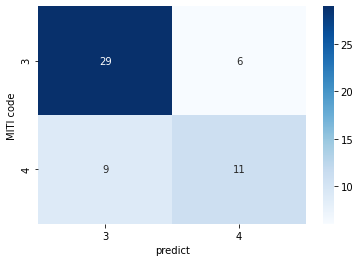

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 混合行列の作成
test_cm = confusion_matrix(q_y, q_predict_list)
sns.heatmap(test_cm, xticklabels=["3", "4"], yticklabels=["3", "4"], annot=True, cmap='Blues')
plt.xlabel('predict')
plt.ylabel('MITI code')
plt.show()

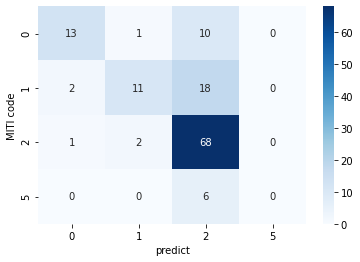

In [54]:
 from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 混合行列の作成
test_cm = confusion_matrix(else_y, else_predict_list)
sns.heatmap(test_cm, xticklabels=["0", "1", "2", "5"], yticklabels=["0", "1", "2", "5"], annot=True, cmap='Blues')
plt.xlabel('predict')
plt.ylabel('MITI code')
plt.show()